In [1]:
%pylab inline
%matplotlib inline

import os
os.chdir("/Users/Bya/git/predictEPL/MyFunctions/")
from dataIO import csv_dic_df

import time
import collections
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/Users/Bya/git/predictEPL/utils/")
sys.path.append("/Users/Bya/git/predictEPL/config/")
sys.path.append("/Users/Bya/git/predictEPL/WebScrapping/")

import paths
import espn_urls
import my_plot
import scrap_espn_gamecast
import emolex
import tokenizer

import useful_methods
from useful_methods import FolderFiles
from useful_methods import csv_dic_df
from useful_methods import FilterDF
from useful_methods import PreprocessingTweet

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Read Soccer Emolex
%time dic_emolex_soccer, dic_emolex_stemmed_soccer = emolex.EmolexSoccerDic()

All Words: 14162
CPU times: user 8.57 s, sys: 204 ms, total: 8.78 s
Wall time: 9.5 s


In [12]:
# choosing data
week = str(13)
GW = 'GW' + week
filenames = FolderFiles(GW + '/SingleGames', paths.READ_PATH_EXTRACTED_CSV, ends='.csv')
filenames

['Chelsea_vs_Norwich.csv',
 'City_vs_Liverpool.csv',
 'Crystal_vs_Sunderland.csv',
 'Everton_vs_Villa.csv',
 'Newcastle_vs_Leicester.csv',
 'Southampton_vs_Stoke.csv',
 'Swansea_vs_Bournemouth.csv',
 'Tottenham_vs_WestHam.csv',
 'WestBromwich_vs_Arsenal.csv']

In [13]:
# Set Game
filename = filenames[1]

# Read DF
os.chdir(paths.READ_PATH_EXTRACTED_CSV + GW + '/SingleGames')
df = csv_dic_df(filename)

start_time = time.time()

# [Filter] DF
dfFilter = FilterDF(df)

# # [Filtered] All, Non-Retweet
# dfFilterEmolex = emolex.CreateEmolexDF(dfFilter, dic_emolex, dic_emolex_stemmed)
# dfFilterEmolexNonRetweet = emolex.CreateEmolexDF(dfFilter[dfFilter['status'] != 'retweet'], dic_emolex, dic_emolex_stemmed)

# # [Filtered] Home, Away
dfFilterEmolexSoccerHome = emolex.CreateEmolexDF(dfFilter[dfFilter['side'] == 'home'], dic_emolex_soccer, dic_emolex_stemmed_soccer)
dfFilterEmolexSoccerAway = emolex.CreateEmolexDF(dfFilter[dfFilter['side'] == 'away'], dic_emolex_soccer, dic_emolex_stemmed_soccer)

# # [Filtered, Non ReTweet] Home, Away
# dfFilterEmolexNonRtHome = emolex.CreateEmolexDF(dfFilter[(dfFilter['side'] == 'home') & (dfFilter['status'] != 'retweet')], dic_emolex, dic_emolex_stemmed)
# dfFilterEmolexNonRtAway = emolex.CreateEmolexDF(dfFilter[(dfFilter['side'] == 'away') & (dfFilter['status'] != 'retweet')], dic_emolex, dic_emolex_stemmed)

# [Filtered, Non ReTweet] Home, Away
dfFilterEmolexSoccerNonRtHome = emolex.CreateEmolexDF(dfFilter[(dfFilter['side'] == 'home') & (dfFilter['status'] != 'retweet')], dic_emolex_soccer, dic_emolex_stemmed_soccer)
dfFilterEmolexSoccerNonRtAway = emolex.CreateEmolexDF(dfFilter[(dfFilter['side'] == 'away') & (dfFilter['status'] != 'retweet')], dic_emolex_soccer, dic_emolex_stemmed_soccer)

print("[Done]: %.2f" % (time.time() - start_time))

[Done]: 101.11


In [14]:
# Scrap Gamecast
url = espn_urls.MatchUrl(GW, filename)
dfGameCast = scrap_espn_gamecast.CreateEspnLiveCommentDF(url)

# Create Goal, Attack, Foul dics
%time goals_dic, attacks_dic_home, attacks_dic_away, fouls_dic_home, fouls_dic_away = scrap_espn_gamecast.CreateGAFdics(dfGameCast)

[Match]: Manchester City VS Liverpool
[Scrap Done]: 31.58 sec
CPU times: user 11.6 ms, sys: 246 µs, total: 11.9 ms
Wall time: 11.9 ms


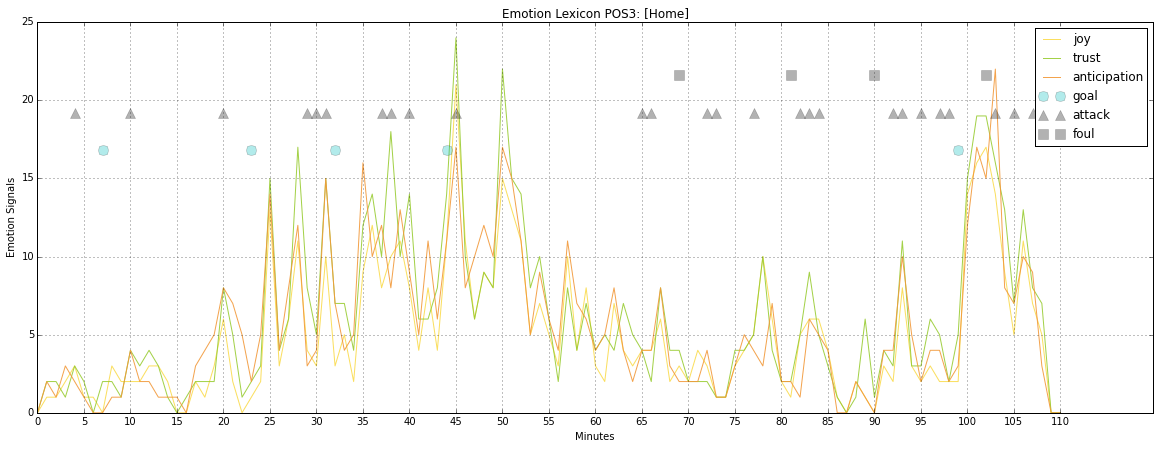

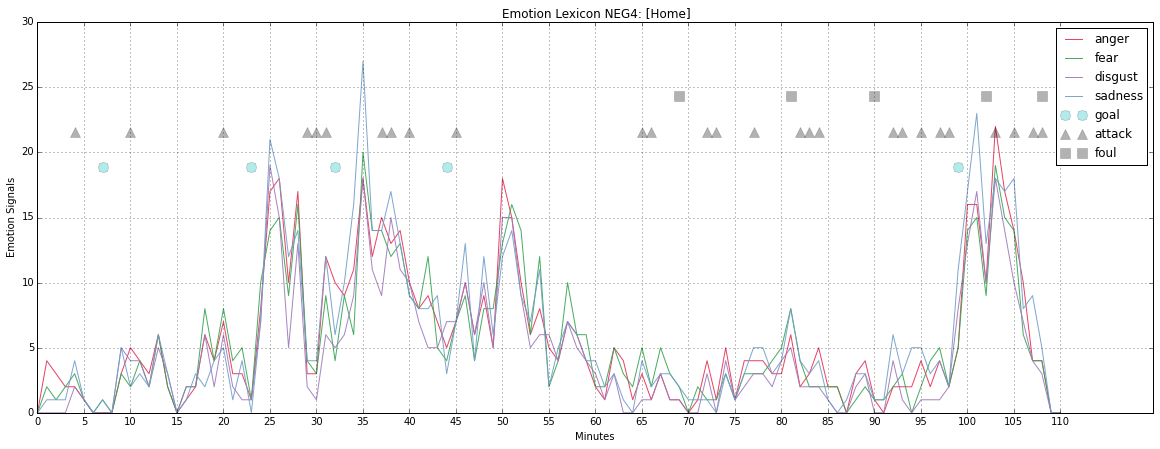

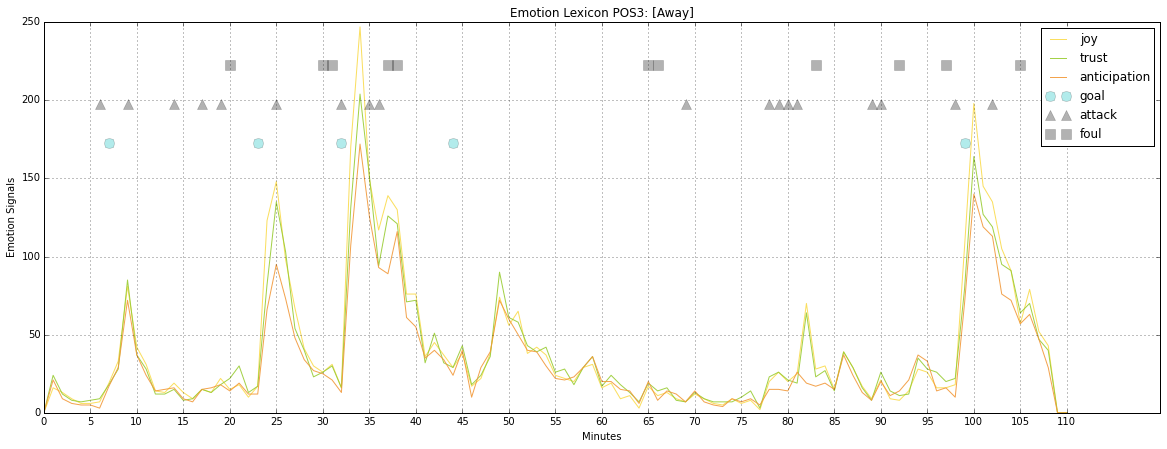

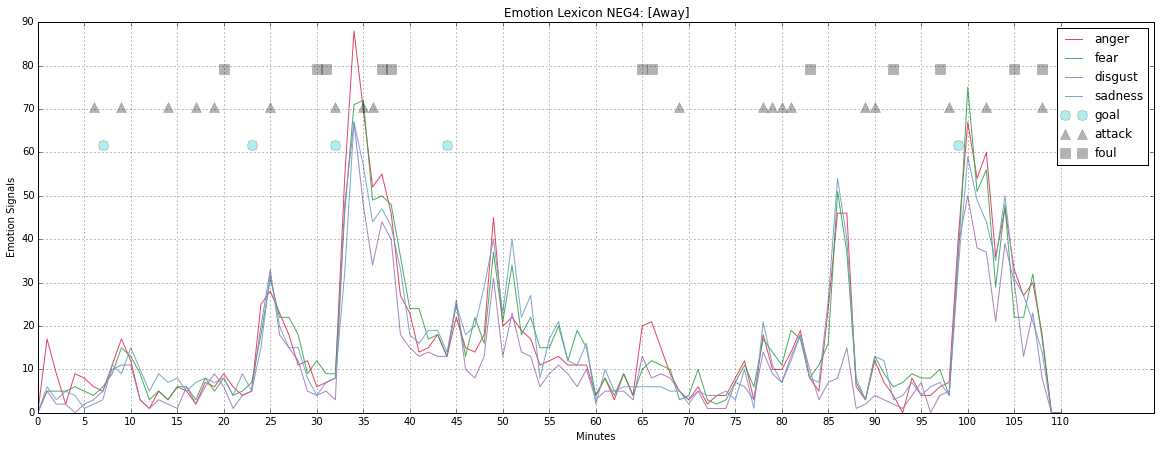

In [15]:
my_plot.Pos3Neg4(dfFilterEmolexSoccerNonRtHome, goals_dic, attacks_dic_home, fouls_dic_home, title='Home')
my_plot.Pos3Neg4(dfFilterEmolexSoccerNonRtAway, goals_dic, attacks_dic_away, fouls_dic_away, title='Away')

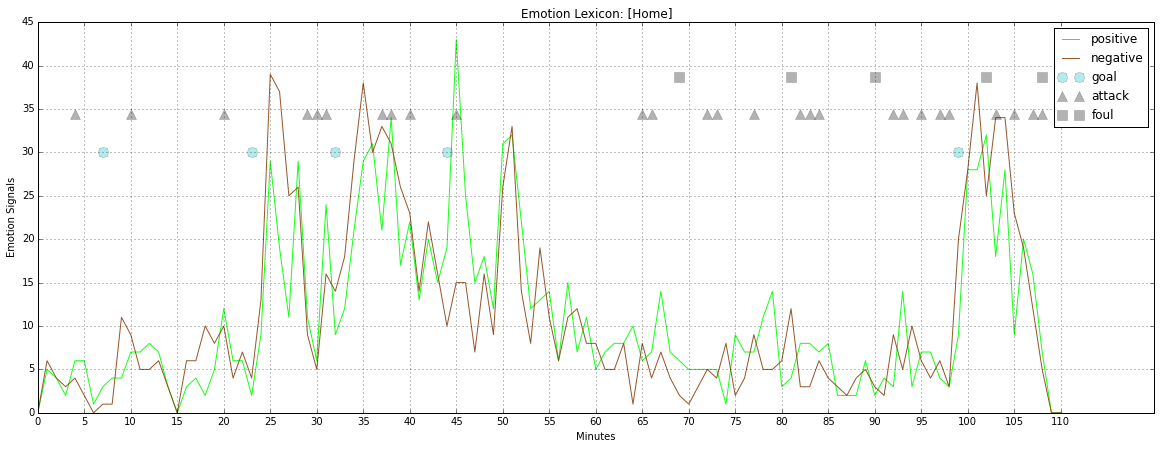

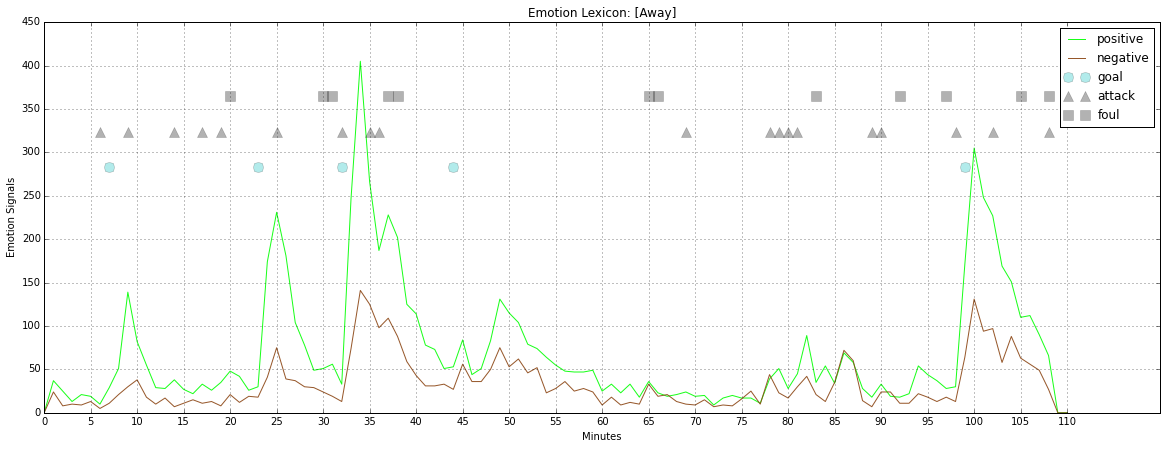

In [16]:
my_plot.EmolexCats(dfFilterEmolexSoccerNonRtHome, ['positive', 'negative'], goals_dic, attacks_dic_home, fouls_dic_home, 'Home')
my_plot.EmolexCats(dfFilterEmolexSoccerNonRtAway, ['positive', 'negative'], goals_dic, attacks_dic_away, fouls_dic_away, 'Away')

# my_plot.EmolexCats(dfFilterEmolexSoccerNonRtAway, ['positive', 'negative'], goals_dic, attacks_dic_away, fouls_dic_away, 'Away')

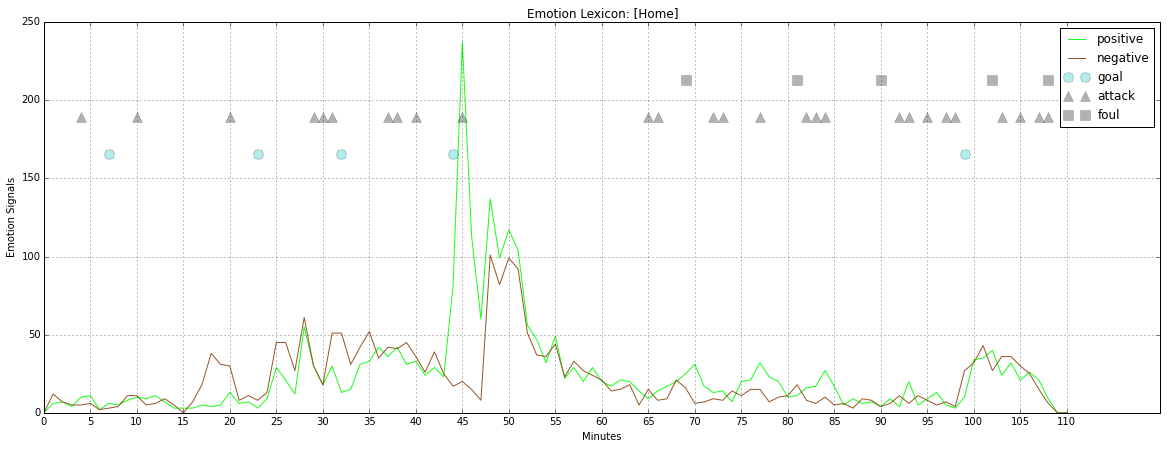

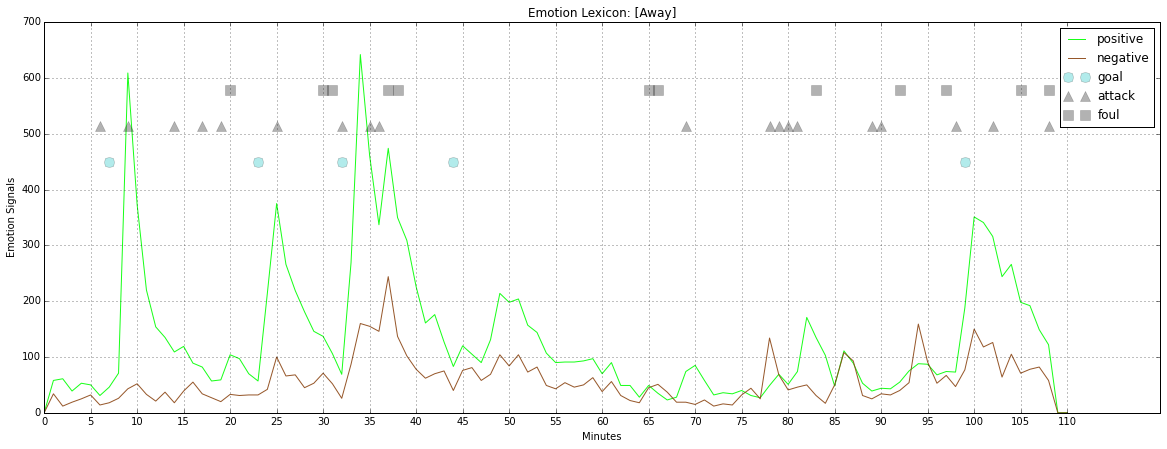

In [17]:
my_plot.EmolexCats(dfFilterEmolexSoccerHome, ['positive', 'negative'], goals_dic, attacks_dic_home, fouls_dic_home, 'Home')
my_plot.EmolexCats(dfFilterEmolexSoccerAway, ['positive', 'negative'], goals_dic, attacks_dic_away, fouls_dic_away, 'Away')

# my_plot.EmolexCats(dfFilterEmolexSoccerNonRtAway, ['positive', 'negative'], goals_dic, attacks_dic_away, fouls_dic_away, 'Away')

# Words Examination

In [21]:
# Set minute and side
start_minute = 90
end_minute = 95
side = 'away'

dfExamine = dfFilter.copy()
dfExamine['ith_minute'] = [int(ith_minte) for ith_minte in dfExamine['ith_minute']]

# extract tweets
tweets = list(dfExamine[
        (dfExamine['side'] == side) &
        (dfExamine['status'] != 'retweet') &
        (dfExamine['ith_minute'] >= start_minute) &
        (dfExamine['ith_minute'] <= end_minute)
    ]['text'])

print("[Tweets Number]: %s\n" % len(tweets))

# Create words lists. PreprocessingTweet
start_time = time.time()
all_words = []
all_words_stemmend = []
for tweet in tweets:
    words = tokenizer.TweetLemmaSoccerLemma(tweet)
    all_words += words

print("[All Words]: %s" % (len(all_words)))
print("[Unique Words]: %s\n" % (len(set(all_words))))

print("[Most Common 10 Words]:")
useful_methods.ShowMostCommon(all_words)
print("\n")

print("[Emolex Words Count]:")
pprint(emolex.CountEmolexWords(dic_emolex_soccer, dic_emolex_stemmed_soccer, all_words, all_words_stemmend))
print("\n")


print("[Passed Time]: %.2f sec" % (time.time() - start_time))

[Tweets Number]: 386

[All Words]: 3145
[Unique Words]: 1061

[Most Common 10 Words]:
[('lfc', 395),
 ('firmino', 122),
 ('benteke', 87),
 ('ynwa', 54),
 ("'s", 44),
 ('liverpool', 43),
 ('today', 40),
 ('game', 35),
 ('come', 34),
 ('ha', 30)]


[Emolex Words Count]:
{'anger': 35,
 'anticipation': 136,
 'disgust': 21,
 'fear': 52,
 'joy': 106,
 'negative': 110,
 'positive': 190,
 'sadness': 43,
 'surprise': 58,
 'trust': 126}


[Passed Time]: 0.48 sec


In [22]:
cat = 'negative'

emolex_words = emolex.EmolexWords(dic_emolex_soccer, dic_emolex_stemmed_soccer, all_words)

cat_words = emolex_words[cat]
useful_methods.ShowMostCommon(cat_words, 20)
len(cat_words)

[('fray', 9),
 ('injury', 6),
 ('escape', 5),
 ('trick', 4),
 ('lost', 2),
 ('kill', 2),
 ('lose', 2),
 ('mess', 2),
 ('loss', 2),
 ('hamstring', 2),
 ('injured', 2),
 ('denied', 2),
 ('cramp', 2),
 ('useless', 1),
 ('snake', 1),
 ('hidden', 1),
 ('lord', 1),
 ('bloody', 1),
 ('broke', 1),
 ('cheap', 1)]


110

In [ ]:
dic_emolex_soccer['lead']

In [20]:
for tweet in tweets:
    if ' good' in tweet:
        print("\n---------")
        print(tweet, '\n\n')
        neg_text = tokenizer.NegationMark(tweet)
        if neg_text:
            print(neg_text, '\n')
        print(emolex.CountEmolexWords(dic_emolex_soccer, dic_emolex_stemmed_soccer,
                                          tokenizer.TweetLemmaSoccerLemma(tweet)))


---------
#ManCityLiverpool The reds are 2 to the good! #LiverpoolFC 


{'joy': 1, 'trust': 1, 'sadness': 0, 'surprise': 1, 'anger': 0, 'positive': 1, 'disgust': 0, 'anticipation': 1, 'negative': 0, 'fear': 0}

---------
Liverpool two to the good against City at the Etihad! #LFC https://t.co/PNatvoOcq2 


{'joy': 1, 'trust': 1, 'sadness': 0, 'surprise': 1, 'anger': 0, 'positive': 1, 'disgust': 0, 'anticipation': 1, 'negative': 0, 'fear': 0}

---------
Been exceptionally good play from #LFC so far 


{'joy': 1, 'trust': 1, 'sadness': 0, 'surprise': 1, 'anger': 0, 'positive': 1, 'disgust': 0, 'anticipation': 1, 'negative': 0, 'fear': 0}

---------
We have excellent defense showing, so far. #YNWA Klopp has done a good job  https://t.co/nEN1tONsxB. 29mins: Yaya Toure fires a dangerous pass into the #LFC area but Skrtel is on hand to intercept and clear the ball 


{'joy': 2, 'trust': 2, 'sadness': 0, 'surprise': 1, 'anger': 1, 'positive': 4, 'disgust': 0, 'anticipation': 2, 'negative': 1,